## Урок 8. Кейс 2. Типы моделей для задачи оттока

Построить модель градиентного бустинга для классификации числа страховых случаев (см. в конце ноутбука). Можно предобработать исходные данные, добавив дополнительные фичи. Также можно использовать различные методы для подбора гиперпараметров. Оценить результаты построенного классификатора, выявить возможные проблемы. Сравнить результаты с полученным на занятии результатом с использованием Пуассоновской регрессии. Проанализировать результаты, предложить способы решения обнаруженных проблем и/или попробовать его улучшить.

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from hyperopt import hp, tpe, space_eval
from hyperopt.fmin import fmin
import warnings
warnings.filterwarnings('ignore')

def SeriesFactorizer(series):
    series, unique = pd.factorize(series)
    reference = {x: i for x, i in enumerate(unique)}
    print(reference)
    return series, reference

In [2]:
df = pd.read_csv('E:\GB\MachineLearning\MPL_R.csv', low_memory=False)
df = df.loc[df.Dataset.isin([5, 6, 7, 8, 9])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Exposure           115155 non-null  float64
 1   LicAge             115155 non-null  int64  
 2   RecordBeg          115155 non-null  object 
 3   RecordEnd          59455 non-null   object 
 4   Gender             115155 non-null  object 
 5   MariStat           115155 non-null  object 
 6   SocioCateg         115155 non-null  object 
 7   VehUsage           115155 non-null  object 
 8   DrivAge            115155 non-null  int64  
 9   HasKmLimit         115155 non-null  int64  
 10  BonusMalus         115155 non-null  int64  
 11  ClaimAmount        115155 non-null  float64
 12  ClaimInd           115155 non-null  int64  
 13  ClaimNbResp        115155 non-null  float64
 14  ClaimNbNonResp     115155 non-null  float64
 15  ClaimNbParking     115155 non-null  float64
 16  Cl

Обработка данных

In [3]:
# обнулить отрицательный ущерб
df.loc[df['ClaimAmount'] < 0, 'ClaimAmount'] = 0

# перекодировать признаки
df['MariStat'], MariStatRef = SeriesFactorizer(df['MariStat'])
df['Gender'], GenderRef = SeriesFactorizer(df['Gender'])

# перекодировать SocioCateg до первой значащей цифры класса 
df['SocioCateg'] = df['SocioCateg'].str.slice(0,4)

# дамми
df = pd.get_dummies(df, columns=['VehUsage','SocioCateg'])

# удалить лишние признаки
df = df.select_dtypes(exclude=['object'])

df['DrivAgeSq'] = df['DrivAge'].apply(lambda x: x**2)

{0: 'Other', 1: 'Alone'}
{0: 'Male', 1: 'Female'}


In [4]:
df['ClaimsCount'] = df['ClaimInd'] + df['ClaimNbResp'] + df['ClaimNbNonResp'] + df['ClaimNbParking'] + df['ClaimNbFireTheft'] + df['ClaimNbWindscreen']
df.loc[df['ClaimAmount'] == 0, 'ClaimsCount'] = 0
df.drop(["ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen"], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 24 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Exposure                         115155 non-null  float64
 1   LicAge                           115155 non-null  int64  
 2   Gender                           115155 non-null  int64  
 3   MariStat                         115155 non-null  int64  
 4   DrivAge                          115155 non-null  int64  
 5   HasKmLimit                       115155 non-null  int64  
 6   BonusMalus                       115155 non-null  int64  
 7   ClaimAmount                      115155 non-null  float64
 8   ClaimInd                         115155 non-null  int64  
 9   OutUseNb                         115155 non-null  float64
 10  RiskArea                         115155 non-null  float64
 11  VehUsage_Private                 115155 non-null  uint8  
 12  Ve

XGBoost для многоклассовой классификации принимает на вход значения меток классов в виде [0, num_classes]. Заменим значение 11 на 10.

In [5]:
df.loc[df['ClaimsCount']==11,'ClaimsCount']=10
df['ClaimsCount'].value_counts()

0.0     104286
2.0       3529
1.0       3339
3.0       2310
4.0       1101
5.0        428
6.0        127
7.0         26
8.0          6
9.0          2
10.0         1
Name: ClaimsCount, dtype: int64

Посмотрим, сколько полисов соответствуют каждому из значений ClaimsCount, используя метод groupby. Для полученных значений также посчитаем нормированную частоту.

In [6]:
FreqCount = pd.DataFrame(data=df['ClaimsCount'].value_counts())
FreqCount.index.name = 'ClaimsCount'
FreqCount.columns = ['Count']
FreqCount['Freq'] = FreqCount['Count']/df.shape[0]
FreqCount 

,Count,Freq
ClaimsCount,,
0.0,104286,0.905614
2.0,3529,0.030646
1.0,3339,0.028996
3.0,2310,0.020060
4.0,1101,0.009561
5.0,428,0.003717
6.0,127,0.001103
7.0,26,0.000226
8.0,6,0.000052


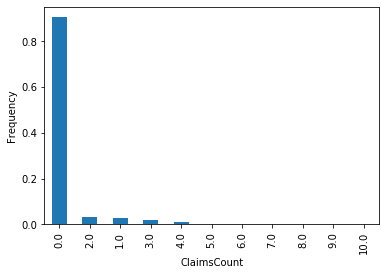

In [7]:
FreqCount.Freq.plot(kind='bar')
plt.ylabel('Frequency')
plt.show()

Заметим, что в данном случае присутствует проблема несбалансированности классов. Поэтому, для того, чтобы по возможности избежать ее, воспользуемся взвешиванием наблюдений для обучения модели. Для этого в исходном наборе данных создадим столбец `weight`. Присвоим ему некоторые значения, например, можно задать `0.05` для значений `ClaimsCount` 0, а для остальных - 1 (Для этого можем использовать функцию `np.where`). Также можно попробовать какой-либо другой способ задания весов, приведенный пример не гарантирует хороших результатов.

In [8]:
df['weight'] = 0
df.loc[df['ClaimsCount'].isin([0]) , 'weight'] = 0.05
df.loc[df['ClaimsCount'].isin([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) , 'weight'] = 1

df['weight'].value_counts()

0.05    104286
1.00     10869
Name: weight, dtype: int64

Разобьем имеющийся набор данных на обучающую, валидационную и тестовую выборки в отношениях 70%/15%/15% соответственно. Зададим зерно для случайного разбиения равным 10.

In [9]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(['ClaimsCount'], axis=1), 
                                                    df['ClaimsCount'], test_size=0.3, random_state=10)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=10)

Далее, создадим объекты `DMatrix` для обучающей, валидационной и тестовой выборок. Для обучающей выборки также укажем параметр `weight` равным полученному ранее столбцу весов. Данный столбец также нужно исключить из объекта передаваемого в параметр `data`.

In [10]:
xgb_train = xgb.DMatrix(data=x_train.drop(['Exposure','weight'], axis=1), label=y_train, weight=x_train['weight'])
xgb_valid = xgb.DMatrix(data=x_valid.drop(['Exposure','weight'], axis=1), label=y_valid, weight=x_valid['weight'])
xgb_test  = xgb.DMatrix(data= x_test.drop(['Exposure','weight'], axis=1), label=y_test, weight=x_test['weight'])

Для оптимизации гиперпараметров можно воспользоваться различными методами.

In [11]:
def objective(params):
    params['max_depth'] = int(params['max_depth'])
    n_b_r = int(params.pop('num_boost_round'))
    data = params.pop('data')
    nfold = params.pop('nfold')
    e_s_r = params.pop('early_stopping_rounds')
    maximize = params.pop('maximize')
    
    cv_result = xgb.cv(params, data, num_boost_round=n_b_r, 
                       nfold=nfold, seed=0, maximize=maximize,
                       early_stopping_rounds=e_s_r)
    
    score = cv_result['test-mlogloss-mean'][-1:].values[0]
    return score

In [12]:
# Определим границы, в которых будем искать гиперпараметры

space_freq = {'data': xgb_train,
              'objective': 'multi:softmax',
              'eval_metric': 'mlogloss',
              'maximize': False,
              'nfold': 2,
              'early_stopping_rounds': 20,
              'num_boost_round': 300,  
              'max_depth': hp.choice('max_depth', [3, 5, 8, 10]),
              'min_child_weight': hp.uniform('min_child_weight', 0, 50),
              'subsample': hp.uniform('subsample', 0.5, 1),
              'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
              'alpha': hp.uniform('alpha', 0, 1),
              'lambda': hp.uniform('lambda', 0, 1),
              'eta': hp.uniform('eta', 0.01, 1),
              'num_class': FreqCount.shape[0]
              }

In [13]:
# Оптимизация (количество итераций снижено для ускорения работы)

best = fmin(fn=objective, space=space_freq, algo=tpe.suggest, max_evals=50)

100%|█████████████████████████████████████████████████████████| 50/50 [22:21<00:00, 26.83s/trial, best loss: 0.9906805]


In [17]:
# Оптимальные гиперпараметры 
best_params = space_eval(space_freq, best)
best_params

{'alpha': 0.7963247389484125,
 'colsample_bytree': 0.5981246432184509,
 'data': <xgboost.core.DMatrix at 0x1c097ba3608>,
 'early_stopping_rounds': 20,
 'eta': 0.1032594996717126,
 'eval_metric': 'mlogloss',
 'lambda': 0.07876880016868651,
 'max_depth': 3,
 'maximize': False,
 'min_child_weight': 10.402404388370453,
 'nfold': 2,
 'num_boost_round': 300,
 'num_class': 11,
 'objective': 'multi:softmax',
 'subsample': 0.9496503692394707}

In [18]:
def train_xgb_best_params(params, dtrain, evals, early_stopping_rounds, evals_result=None, verbose_eval=None):
    par = params.copy()
    for label in ['nfold', 'data', 'early_stopping_rounds']:
        del par[label]
    n_b_r = int(par.pop('num_boost_round'))
    maximize = par.pop('maximize')
    
    return xgb.train(params=par, dtrain=dtrain, num_boost_round=n_b_r, evals=evals, maximize=maximize,
                     early_stopping_rounds=early_stopping_rounds, evals_result=evals_result, verbose_eval=verbose_eval)

Далее обучим нашу модель с оптимальными параметрами

In [20]:
progress = dict()
xgb_freq = train_xgb_best_params(best_params, xgb_train, 
                                 [(xgb_train, "train"),(xgb_valid, "valid")], 
                                 early_stopping_rounds=50, evals_result=progress, 
                                 verbose_eval=False)

Посчитаем метрики accuracy и f1 на наших наборах данных, также можем визуализировать confusion matrix, например, с помощью `plt.imshow()`. Можно использовать предложенный ниже код.

In [21]:
dfsets = [{'set': 'train', 'dmat': xgb_train, 'target': y_train},
          {'set': 'valid', 'dmat': xgb_valid, 'target': y_valid},
          {'set': 'test', 'dmat': xgb_test, 'target': y_test}]
for dfset in dfsets:
    class_preds = xgb_freq.predict(dfset['dmat']) 
    print('F1 Score on ' + str(dfset['set'])+':', f1_score(dfset['target'], class_preds, average='micro')) 

F1 Score on train: 0.9452659785629218
F1 Score on valid: 0.9383430787934928
F1 Score on test: 0.938751881440315


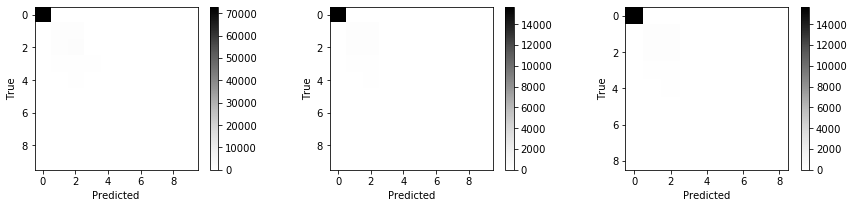

In [22]:
plt.subplots(1,3, figsize=(15,3))
for i in range(len(dfsets)):
    confmatrix = confusion_matrix(dfsets[i]['target'], xgb_freq.predict(dfsets[i]['dmat']))
    plt.subplot(1,3,i+1)
    plt.imshow(confmatrix, cmap='Greys')
    plt.colorbar()
    plt.ylabel('True')
    plt.xlabel('Predicted')
plt.show()

Как вы оцениваете качество построенной модели? Какие проблемы могут здесь присутствовать? Как можно улучшить результат?

__На матрице хорошо видно, что из-за преобладания класса 0 (сильнейший дисбаланс классов), модель может ошибочно относить к нему другие метки. Добавление весовых коэффициентов не сильно улучшает метрику и не решает проблему дисбаланса классов.<br>
Типовые синтетические фичи (умножение, деление, возведение в степень) не улучшали метрику.__

__Возможно, что вместо весов нужно использовать другие инструменты. Может, oversampling. Возможно также нужно пересмотреть механизм подбора параметров.__ 